In [6]:
!pip install seaborn --quiet
!pip install nilearn --quiet

import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# Figure settings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from nilearn import plotting, datasets
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

N_SUBJECTS = 339
N_PARCELS = 360
TR = 0.72  # Time resolution, in seconds
HEMIS = ["Right", "Left"]
N_RUNS = 2
EXPERIMENTS = {
    'MOTOR': {'runs': [5, 6], 'cond': ['lf', 'rf', 'lh', 'rh', 't', 'cue']},
    'WM': {'runs': [7, 8], 'cond': ['0bk_body', '0bk_faces', '0bk_places', '0bk_tools', '2bk_body', '2bk_faces', '2bk_places', '2bk_tools']},
    'EMOTION': {'runs': [9, 10], 'cond': ['fear', 'neut']},
    'GAMBLING': {'runs': [11, 12], 'cond': ['loss', 'win']},
    'LANGUAGE': {'runs': [13, 14], 'cond': ['math', 'story']},
    'RELATIONAL': {'runs': [15, 16], 'cond': ['match', 'relation']},
    'SOCIAL': {'runs': [17, 18], 'cond': ['mental', 'rnd']}
}

HCP_DIR = r"/home/amirreza/neuromatch/hcp_task"

def load_single_timeseries(subject, experiment, run, dir, remove_mean=True):
    """Load timeseries data for a single subject and single run.

    Args:
        subject (str): Subject ID to load
        experiment (str): Name of experiment
        run (int): 0-based run index (0 or 1 for the task)
        dir (str): Path to HCP directory
        remove_mean (bool): If True, subtract the parcel-wise mean

    Returns:
        ts (n_parcel x n_timepoint array): Array of BOLD data values or None if loading fails.
    """
    bold_run = EXPERIMENTS[experiment]['runs'][run]
    bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
    bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
    full_bold_path = os.path.join(bold_path, bold_file)

    try:
        ts = np.load(full_bold_path)
        if remove_mean:
            ts -= ts.mean(axis=1, keepdims=True)
        return ts
    except FileNotFoundError:
        print(f"DEBUG: Timeseries file not found for S{subject}/Run{run} ({full_bold_path})")
        return None
    except Exception as e:
        print(f"DEBUG: Error loading timeseries for S{subject}/Run{run} ({full_bold_path}): {e}")
        return None

def load_evs(subject, experiment, run, dir):
    """Load EVs (explanatory variables) data for one task experiment.

    Args:
        subject (str): Subject ID to load
        experiment (str): Name of experiment
        run (int): 0-based run index (0 or 1 for the task)
        dir (str): Path to HCP directory

    Returns:
        evs (list of lists): A list of frames associated with each condition, clipped to valid timepoints, or None if loading fails.
    """
    frames_list = []
    task_key = 'tfMRI_' + experiment + '_' + ['RL', 'LR'][run]
    
    # Load time series to get number of timepoints for clipping EVs
    ts = load_single_timeseries(subject, experiment, run, dir, remove_mean=False)
    if ts is None:
        print(f"DEBUG: Skipping EV loading for S{subject}/Run{run} because timeseries failed to load.")
        return None # If time series couldn't be loaded, EVs can't be reliably clipped

    n_timepoints = ts.shape[1]

    for cond in EXPERIMENTS[experiment]['cond']:
        ev_file = os.path.join(dir, "subjects", str(subject), "EVs", task_key, f"{cond}.txt")
        try:
            ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
            ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
            start = np.floor(ev["onset"] / TR).astype(int)
            duration = np.ceil(ev["duration"] / TR).astype(int)
            frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
            clipped_frames = []
            for frame in frames:
                valid_frames = frame[frame < n_timepoints]
                if len(valid_frames) > 0:
                    clipped_frames.append(valid_frames)
            frames_list.append(clipped_frames if clipped_frames else [])
            if not clipped_frames:
                # print(f"DEBUG: No valid clipped frames for S{subject}/Run{run}/{cond}. Raw frames: {frames}")
                pass # Suppress this for less verbose output unless deeply debugging specific EV issues
        except FileNotFoundError:
            # print(f"DEBUG: EV file not found for S{subject}/Run{run}/{cond} ({ev_file}). Appending empty.")
            frames_list.append([]) # Append empty list if file is missing
        except (ValueError, IndexError) as e: # Handle cases where EV file might be empty or malformed
            # print(f"DEBUG: Error parsing EV file {ev_file} for S{subject}/Run{run}/{cond}: {e}. Appending empty.")
            frames_list.append([])
        except Exception as e: # Catch any other unexpected errors during EV loading
            # print(f"DEBUG: An unexpected error occurred with EV file {ev_file} for S{subject}/Run{run}/{cond}: {e}. Appending empty.")
            frames_list.append([])
    return frames_list

# --- Data Aggregation and Sample Creation ---
print("Starting Data Aggregation and Sample Creation...")

all_samples = [] # List to store (N_parcels, N_timepoints) arrays for each sample
all_labels = []  # List to store corresponding labels (0 or 1) for each sample
sample_metadata = [] # To store subject, run_idx, and task_type for each sample

wm_0bk_conditions = ['0bk_body', '0bk_faces', '0bk_places', '0bk_tools']
wm_2bk_conditions = ['2bk_body', '2bk_faces', '2bk_places', '2bk_tools']
all_wm_conditions = EXPERIMENTS["WM"]["cond"] # All WM conditions for easy index lookup

# Use tqdm for a progress bar over subjects
for sub_idx in tqdm(range(N_SUBJECTS), desc="Processing Subjects"):
    subject_id = str(sub_idx) # Subject IDs are typically strings in HCP
    
    for run_idx in range(N_RUNS):
        # --- Common loading for the current subject and run ---
        full_ts_run = load_single_timeseries(subject_id, "WM", run_idx, HCP_DIR, remove_mean=False)
        if full_ts_run is None:
            continue # Skip to next run/subject if time series is missing

        evs_run = load_evs(subject_id, "WM", run_idx, HCP_DIR)
        if evs_run is None:
            continue # Skip if EVs are missing (or timeseries failed previously)

        # --- Process 0-back conditions ---
        current_0bk_ts_list = []
        for cond_name in wm_0bk_conditions:
            if cond_name not in all_wm_conditions:
                print(f"DEBUG: Warning: Condition {cond_name} not found in EXPERIMENTS['WM']['cond']. Skipping.")
                continue

            cond_ev_idx = all_wm_conditions.index(cond_name)
            frames_for_this_cond = evs_run[cond_ev_idx]
            
            # Filter out any empty arrays before extending
            # This ensures flat_frames_this_cond only contains arrays with actual data
            flat_frames_this_cond = [arr for arr in frames_for_this_cond if arr is not None and len(arr) > 0]
            
            # This is the critical change: Only attempt concatenate if flat_frames_this_cond is not empty
            # AND contains actual arrays
            if flat_frames_this_cond:
                # np.concatenate will now receive a list of non-empty arrays
                unique_flat_frames = np.unique(np.concatenate(flat_frames_this_cond)).astype(int)
                valid_frames_this_cond = unique_flat_frames[unique_flat_frames < full_ts_run.shape[1]]
                if len(valid_frames_this_cond) > 0:
                    current_0bk_ts_list.append(full_ts_run[:, valid_frames_this_cond])
        
        if current_0bk_ts_list:
            min_len_0bk = min(ts_arr.shape[1] for ts_arr in current_0bk_ts_list)
            if min_len_0bk > 0:
                avg_0bk_ts_subject_run = np.mean([ts_arr[:, :min_len_0bk] for ts_arr in current_0bk_ts_list], axis=0)
                all_samples.append(avg_0bk_ts_subject_run)
                all_labels.append(0) # Label for 0-back
                sample_metadata.append({'subject': subject_id, 'run_idx': run_idx, 'task_type': '0-back'})


        # --- Process 2-back conditions ---
        current_2bk_ts_list = []
        for cond_name in wm_2bk_conditions:
            if cond_name not in all_wm_conditions:
                print(f"DEBUG: Warning: Condition {cond_name} not found in EXPERIMENTS['WM']['cond']. Skipping.")
                continue

            cond_ev_idx = all_wm_conditions.index(cond_name)
            frames_for_this_cond = evs_run[cond_ev_idx]
            
            # Filter out any empty arrays before extending
            flat_frames_this_cond = [arr for arr in frames_for_this_cond if arr is not None and len(arr) > 0]
            
            if flat_frames_this_cond:
                unique_flat_frames = np.unique(np.concatenate(flat_frames_this_cond)).astype(int)
                valid_frames_this_cond = unique_flat_frames[unique_flat_frames < full_ts_run.shape[1]]
                if len(valid_frames_this_cond) > 0:
                    current_2bk_ts_list.append(full_ts_run[:, valid_frames_this_cond])

        if current_2bk_ts_list:
            min_len_2bk = min(ts_arr.shape[1] for ts_arr in current_2bk_ts_list)
            if min_len_2bk > 0:
                avg_2bk_ts_subject_run = np.mean([ts_arr[:, :min_len_2bk] for ts_arr in current_2bk_ts_list], axis=0)
                all_samples.append(avg_2bk_ts_subject_run)
                all_labels.append(1) # Label for 2-back
                sample_metadata.append({'subject': subject_id, 'run_idx': run_idx, 'task_type': '2-back'})

print("\nData Aggregation Complete.")
print(f"Total samples created: {len(all_samples)}")
print(f"Total labels created: {len(all_labels)}")

# Example of a sample's shape (might vary slightly in timepoints due to min_len per sample)
if all_samples:
    print(f"Shape of first sample (Parcels x Timepoints): {all_samples[0].shape}")
    print(f"Corresponding label: {all_labels[0]}")
    print(f"Metadata for first sample: {sample_metadata[0]}")
else:
    print("No samples were created. This indicates a potential issue with data loading or EV files for all subjects/runs.")

Starting Data Aggregation and Sample Creation...


Processing Subjects:   0%|          | 0/339 [00:00<?, ?it/s]


Data Aggregation Complete.
Total samples created: 1356
Total labels created: 1356
Shape of first sample (Parcels x Timepoints): (360, 39)
Corresponding label: 0
Metadata for first sample: {'subject': '0', 'run_idx': 0, 'task_type': '0-back'}


In [20]:
# --- Load Regions And Networks ---
print("Loading region and network information...")
regions = np.load(os.path.join(HCP_DIR, "regions.npy")).T
region_info = dict(name=regions[0].tolist(),
                   network=regions[1],
                   hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2))

# Extract the raw network names (strings) for each parcel
raw_network_names = region_info['network']

# Create a mapping from unique network names (strings) to integer IDs
unique_network_names = np.unique(raw_network_names)
network_name_to_id = {name: i for i, name in enumerate(unique_network_names)}

# Now, create the parcel_to_network_mapping using these integer IDs
parcel_to_network_mapping = np.array([network_name_to_id[name] for name in raw_network_names]).astype(int)

# Determine the number of unique networks
N_NETWORKS = len(unique_network_names) # This is simply the count of unique names

print(f"Loaded {N_PARCELS} parcels mapped to {N_NETWORKS} networks.")
print(f"Network names and their integer IDs: {network_name_to_id}")
# print(f"Example parcel to network mapping for first 10 parcels: {parcel_to_network_mapping[:10]}")


# --- Feature Extraction ---
print("\nStarting Feature Extraction (Networks, NOT Parcels)...")

all_features = [] # List to store the vectorized FC features for each sample

for i, sample_ts in tqdm(enumerate(all_samples), total=len(all_samples), desc="Extracting Features"):
    # sample_ts has shape (N_parcels, N_timepoints)
    
    # 1. Aggregate Parcel Time Series to Network Time Series
    # Initialize network time series with zeros
    # Ensure network_time_series can accommodate the timepoints from sample_ts
    network_time_series = np.zeros((N_NETWORKS, sample_ts.shape[1]))

    # For each network, average the time series of its constituent parcels
    for network_id in range(N_NETWORKS):
        # Find all parcels that belong to the current network_id
        parcels_in_network = np.where(parcel_to_network_mapping == network_id)[0]
        
        if len(parcels_in_network) > 0:
            # Average the time series for these parcels
            network_time_series[network_id, :] = np.mean(sample_ts[parcels_in_network, :], axis=0)
        # else:
            # If a network has no parcels assigned (unlikely with this data structure),
            # its time series will remain zeros. This is typically okay but worth noting.

    # 2. Compute Network-level Functional Connectivity (Pearson Correlation)
    # np.corrcoef needs at least 2 time points to calculate correlation.
    # If a sample has only 1 time point, this will result in NaNs.
    # We should handle cases where network_time_series might have constant rows (std=0)
    # or not enough timepoints after aggregation.

    if sample_ts.shape[1] < 2:
        # print(f"DEBUG: Sample {i} has less than 2 timepoints ({sample_ts.shape[1]}). Skipping FC for this sample.")
        # Append an array of NaNs or zeros for this sample if it has insufficient timepoints
        # The number of features will be N_NETWORKS * (N_NETWORKS - 1) / 2
        num_features_expected = N_NETWORKS * (N_NETWORKS - 1) // 2
        all_features.append(np.zeros(num_features_expected)) # Or np.full(num_features_expected, np.nan)
        continue # Skip to the next sample

    network_fc_matrix = np.corrcoef(network_time_series)
    
    # Handle potential NaNs (e.g., if a network time series was all zeros due to no/bad parcels,
    # or if there was only one time point leading to a NaN correlation).
    network_fc_matrix = np.nan_to_num(network_fc_matrix, nan=0.0)

    # 3. Fisher's r-to-z Transformation
    # Apply arctanh to all correlation coefficients
    # Clip values slightly to avoid infinite values from arctanh(+-1)
    network_fc_matrix = np.clip(network_fc_matrix, -0.9999, 0.9999) 
    transformed_fc_matrix = np.arctanh(network_fc_matrix)

    # 4. Vectorize Features (Upper Triangle)
    # Get indices for the upper triangle (excluding the diagonal)
    upper_triangle_indices = np.triu_indices(N_NETWORKS, k=1)
    
    # Extract the values and flatten them into a 1D feature vector
    feature_vector = transformed_fc_matrix[upper_triangle_indices]
    
    all_features.append(feature_vector)

print("\nFeature Extraction Complete.")
print(f"Total feature vectors created: {len(all_features)}")

# Convert the list of feature vectors to a single NumPy array for machine learning
X = np.array(all_features)
y = np.array(all_labels) # Assuming all_labels is available from previous step

print(f"Shape of feature matrix X: {X.shape} (N_samples, N_features)")
print(f"Shape of label vector y: {y.shape} (N_samples,)")

# Verify the number of features matches the expected formula
expected_features = N_NETWORKS * (N_NETWORKS - 1) // 2
print(f"Expected number of features per sample: {expected_features}")
if X.shape[1] == expected_features:
    print("Number of features matches expected formula.")
else:
    print("WARNING: Number of features does NOT match expected formula.")

# Display first few features of the first sample
if len(all_features) > 0:
    print(f"\nFirst 10 features of the first sample:\n{all_features[0][:10]}")

Loading region and network information...
Loaded 360 parcels mapped to 12 networks.
Network names and their integer IDs: {np.str_('Auditory'): 0, np.str_('Cingulo-Oper'): 1, np.str_('Default'): 2, np.str_('Dorsal-atten'): 3, np.str_('Frontopariet'): 4, np.str_('Language'): 5, np.str_('Orbito-Affec'): 6, np.str_('Posterior-Mu'): 7, np.str_('Somatomotor'): 8, np.str_('Ventral-Mult'): 9, np.str_('Visual1'): 10, np.str_('Visual2'): 11}

Starting Feature Extraction (Networks, NOT Parcels)...


Extracting Features:   0%|          | 0/1356 [00:00<?, ?it/s]


Feature Extraction Complete.
Total feature vectors created: 1356
Shape of feature matrix X: (1356, 66) (N_samples, N_features)
Shape of label vector y: (1356,) (N_samples,)
Expected number of features per sample: 66
Number of features matches expected formula.

First 10 features of the first sample:
[1.01982904 0.53878408 0.33331954 0.75298133 0.30903056 0.14662
 0.50700821 1.42919936 0.36214051 0.50632154]


In [ ]:
from sklearn.model_selection import StratifiedGroupKFold

print("Starting Data Splitting...")

# 1. Create a Series of Subject IDs corresponding to each sample in X and y
# The 'subject' is stored as a string in sample_metadata
all_subjects = np.array([meta['subject'] for meta in sample_metadata])

# Get unique subjects to define groups for splitting
unique_subjects = np.unique(all_subjects)

# Map each sample to its corresponding subject group ID
# This creates a numerical group ID for each sample, which StratifiedGroupKFold understands.
# You could also directly pass all_subjects (string array) as 'groups'.
subject_id_map = {sub: i for i, sub in enumerate(unique_subjects)}
groups = np.array([subject_id_map[sub] for sub in all_subjects])


# 2. Perform Subject-Wise and Stratified Split
# We'll use StratifiedGroupKFold for this.
# For a simple train/test split, we can set n_splits=X, and then just take the first fold.
# Let's aim for a common split, e.g., 80% train, 20% test.
# Since StratifiedGroupKFold performs K-Fold cross-validation, we'll configure it
# to give us roughly one train/test split, and then extract that.

# Calculate approximate number of subjects for test set
# Aim for ~20% of subjects in the test set.
# N_SUBJECTS is defined globally from the previous setup (e.g., 339)
num_test_subjects = int(N_SUBJECTS * 0.20)
if num_test_subjects == 0: # Ensure at least one subject in test if N_SUBJECTS is very small
    num_test_subjects = 1 
num_train_subjects = N_SUBJECTS - num_test_subjects

print(f"Total unique subjects: {N_SUBJECTS}")
print(f"Targeting approximately {num_train_subjects} subjects for training and {num_test_subjects} for testing.")

# StratifiedGroupKFold requires n_splits to be at least 2.
# To get one split, we can make n_splits large enough that one fold covers ~20% of data.
# A simpler approach for a single split is to iterate a few times until desired split ratio is met,
# or set n_splits based on inverse of test ratio and take first split.
# Let's use 5 folds, which means each test fold is ~20% of subjects.
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# Get the indices for one train/test split
# We iterate once to get the first split
for train_idx, test_idx in sgkf.split(X, y, groups):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    train_subjects = all_subjects[train_idx]
    test_subjects = all_subjects[test_idx]
    
    # Break after the first split if you only need one fixed split
    break 

print("\nData Splitting Complete.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}") # type: ignore
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}") # type: ignore

# Verify subject-wise split (no overlap in subjects between train and test)
train_unique_subjects = np.unique(train_subjects) # type: ignore
test_unique_subjects = np.unique(test_subjects) # type: ignore
overlapping_subjects = np.intersect1d(train_unique_subjects, test_unique_subjects)

print(f"\nUnique subjects in training set: {len(train_unique_subjects)}")
print(f"Unique subjects in test set: {len(test_unique_subjects)}")
print(f"Number of overlapping subjects between train and test: {len(overlapping_subjects)}")
if len(overlapping_subjects) == 0:
    print("Subject-wise split successfully maintained (no subject overlap).")
else:
    print("WARNING: Subject overlap detected! Check splitting logic.")

# Verify stratification (balanced labels in train and test)
print("\nLabel distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True)) # type: ignore
print("\nLabel distribution in test set:")
print(pd.Series(y_test).value_counts(normalize=True)) # type: ignore

Starting Data Splitting...
Total unique subjects: 339
Targeting approximately 272 subjects for training and 67 for testing.

Data Splitting Complete.
X_train shape: (1084, 66), y_train shape: (1084,)
X_test shape: (272, 66), y_test shape: (272,)

Unique subjects in training set: 271
Unique subjects in test set: 68
Number of overlapping subjects between train and test: 0
Subject-wise split successfully maintained (no subject overlap).

Label distribution in training set:
0    0.5
1    0.5
Name: proportion, dtype: float64

Label distribution in test set:
0    0.5
1    0.5
Name: proportion, dtype: float64


In [22]:
from sklearn.preprocessing import StandardScaler

print("Starting Preprocessing (Scaling)...")

# 1. Initialize the StandardScaler
scaler = StandardScaler()

# 2. Fit the scaler ONLY on the training data (X_train)
scaler.fit(X_train)

# 3. Transform both the training and testing data using the fitted scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nPreprocessing (Scaling) Complete.")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

# Optionally, you can print some statistics to verify scaling (mean should be close to 0, std close to 1)
# print(f"\nMean of X_train_scaled (first 5 features): {X_train_scaled.mean(axis=0)[:5]}")
# print(f"Std dev of X_train_scaled (first 5 features): {X_train_scaled.std(axis=0)[:5]}")
# print(f"Mean of X_test_scaled (first 5 features): {X_test_scaled.mean(axis=0)[:5]}")
# print(f"Std dev of X_test_scaled (first 5 features): {X_test_scaled.std(axis=0)[:5]}")

Starting Preprocessing (Scaling)...

Preprocessing (Scaling) Complete.
X_train_scaled shape: (1084, 66)
X_test_scaled shape: (272, 66)


In [29]:
import os
import joblib
import numpy as np # Ensure numpy is imported for np.logspace
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb # New import for XGBoost

# Assume X_train, X_test, y_train, y_test are available from previous steps (unscaled data from Data Splitting).

print("Starting Model Selection and Hyperparameter Tuning (with expanded grids and XGBoost)...")
print("This step will take significantly longer due to expanded search spaces.")

# Create a directory to save models if it doesn't exist
output_dir = "saved_models"
os.makedirs(output_dir, exist_ok=True)
print(f"Models will be saved in: {output_dir}")

# Dictionary to store the best estimator and best score for each model
best_models = {}
best_scores = {}

# Define cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5-fold CV

# --- Logistic Regression ---
print("\n--- Tuning Logistic Regression ---")
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42, solver='liblinear', max_iter=2000)) # Increased max_iter
])
lr_param_grid = {
    'logreg__C': np.logspace(-3, 2, 6), # More values: 0.001, 0.01, 0.1, 1, 10, 100
    'logreg__penalty': ['l1', 'l2'] # Add L1 penalty
}
grid_lr = GridSearchCV(lr_pipeline, lr_param_grid, cv=cv_strategy, scoring='accuracy', n_jobs=-1, verbose=2) # Verbose 2 for more detail
try:
    grid_lr.fit(X_train, y_train)
    if grid_lr.best_estimator_ is not None:
        best_models['LogisticRegression'] = grid_lr.best_estimator_
        best_scores['LogisticRegression'] = grid_lr.best_score_
        print(f"Best LR Score: {grid_lr.best_score_:.4f}")
        print(f"Best LR Params: {grid_lr.best_params_}")
        joblib.dump(grid_lr.best_estimator_, os.path.join(output_dir, 'best_logistic_regression_model.joblib'))
        print("Best Logistic Regression model saved.")
    else:
        print("WARNING: Logistic Regression GridSearchCV did not find a best estimator. Model not saved.")
except Exception as e:
    print(f"ERROR during Logistic Regression tuning: {e}")


# --- Support Vector Classifier (SVC) ---
print("\n--- Tuning SVC ---")
svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=42, probability=True)) # Set probability=True for ROC AUC later if needed
])
svc_param_grid = {
    'svc__C': [0.1, 1, 10, 100], # Expanded C
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': ['scale', 'auto', 0.001, 0.01, 0.1] # Expanded gamma values
}
grid_svc = GridSearchCV(svc_pipeline, svc_param_grid, cv=cv_strategy, scoring='accuracy', n_jobs=-1, verbose=2)
try:
    grid_svc.fit(X_train, y_train)
    if grid_svc.best_estimator_ is not None:
        best_models['SVC'] = grid_svc.best_estimator_
        best_scores['SVC'] = grid_svc.best_score_
        print(f"Best SVC Score: {grid_svc.best_score_:.4f}")
        print(f"Best SVC Params: {grid_svc.best_params_}")
        joblib.dump(grid_svc.best_estimator_, os.path.join(output_dir, 'best_svc_model.joblib'))
        print("Best SVC model saved.")
    else:
        print("WARNING: SVC GridSearchCV did not find a best estimator. Model not saved.")
except Exception as e:
    print(f"ERROR during SVC tuning: {e}")


# --- Random Forest Classifier ---
print("\n--- Tuning Random Forest Classifier ---")
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])
rf_param_grid = {
    'rf__n_estimators': [100, 200, 300, 400], # Expanded n_estimators
    'rf__max_depth': [None, 10, 20, 30], # Expanded max_depth
    'rf__min_samples_split': [2, 5, 10], # Expanded min_samples_split
    'rf__min_samples_leaf': [1, 2, 4] # Added min_samples_leaf
}
grid_rf = GridSearchCV(rf_pipeline, rf_param_grid, cv=cv_strategy, scoring='accuracy', n_jobs=-1, verbose=2)
try:
    grid_rf.fit(X_train, y_train)
    if grid_rf.best_estimator_ is not None:
        best_models['RandomForestClassifier'] = grid_rf.best_estimator_
        best_scores['RandomForestClassifier'] = grid_rf.best_score_
        print(f"Best RF Score: {grid_rf.best_score_:.4f}")
        print(f"Best RF Params: {grid_rf.best_params_}")
        joblib.dump(grid_rf.best_estimator_, os.path.join(output_dir, 'best_random_forest_model.joblib'))
        print("Best Random Forest Classifier model saved.")
    else:
        print("WARNING: Random Forest GridSearchCV did not find a best estimator. Model not saved.")
except Exception as e:
    print(f"ERROR during Random Forest tuning: {e}")


# --- Gradient Boosting Classifier ---
print("\n--- Tuning Gradient Boosting Classifier ---")
gb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingClassifier(random_state=42))
])
gb_param_grid = {
    'gb__n_estimators': [100, 200, 300], # Expanded n_estimators
    'gb__learning_rate': [0.01, 0.05, 0.1, 0.2], # Finer learning_rate
    'gb__max_depth': [3, 5, 7], # Expanded max_depth
    'gb__subsample': [0.8, 1.0] # Added subsample
}
grid_gb = GridSearchCV(gb_pipeline, gb_param_grid, cv=cv_strategy, scoring='accuracy', n_jobs=-1, verbose=2)
try:
    grid_gb.fit(X_train, y_train)
    if grid_gb.best_estimator_ is not None:
        best_models['GradientBoostingClassifier'] = grid_gb.best_estimator_
        best_scores['GradientBoostingClassifier'] = grid_gb.best_score_
        print(f"Best GB Score: {grid_gb.best_score_:.4f}")
        print(f"Best GB Params: {grid_gb.best_params_}")
        joblib.dump(grid_gb.best_estimator_, os.path.join(output_dir, 'best_gradient_boosting_model.joblib'))
        print("Best Gradient Boosting Classifier model saved.")
    else:
        print("WARNING: Gradient Boosting GridSearchCV did not find a best estimator. Model not saved.")
except Exception as e:
    print(f"ERROR during Gradient Boosting tuning: {e}")


# --- K-Nearest Neighbors Classifier ---
print("\n--- Tuning K-Nearest Neighbors Classifier ---")
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15], # Expanded n_neighbors
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2] # Added p for Manhattan (1) vs Euclidean (2) distance
}
grid_knn = GridSearchCV(knn_pipeline, knn_param_grid, cv=cv_strategy, scoring='accuracy', n_jobs=-1, verbose=2)
try:
    grid_knn.fit(X_train, y_train)
    if grid_knn.best_estimator_ is not None:
        best_models['KNeighborsClassifier'] = grid_knn.best_estimator_
        best_scores['KNeighborsClassifier'] = grid_knn.best_score_
        print(f"Best KNN Score: {grid_knn.best_score_:.4f}")
        print(f"Best KNN Params: {grid_knn.best_params_}")
        joblib.dump(grid_knn.best_estimator_, os.path.join(output_dir, 'best_k_neighbors_model.joblib'))
        print("Best K-Nearest Neighbors Classifier model saved.")
    else:
        print("WARNING: K-Nearest Neighbors GridSearchCV did not find a best estimator. Model not saved.")
except Exception as e:
    print(f"ERROR during K-Nearest Neighbors tuning: {e}")


# --- XGBoost Classifier (NEW MODEL) ---
print("\n--- Tuning XGBoost Classifier ---")
# XGBoost is often very powerful, but ensure you have the 'xgboost' library installed:
# pip install xgboost
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()), # Scaling is generally beneficial for XGBoost
    ('xgb', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')) # Suppress warning
])
xgb_param_grid = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__max_depth': [3, 5, 7],
    'xgb__subsample': [0.8, 1.0], # Subsample ratio of the training instance
    'xgb__colsample_bytree': [0.8, 1.0] # Subsample ratio of columns when constructing each tree
}
grid_xgb = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=cv_strategy, scoring='accuracy', n_jobs=-1, verbose=2)
try:
    grid_xgb.fit(X_train, y_train)
    if grid_xgb.best_estimator_ is not None:
        best_models['XGBoostClassifier'] = grid_xgb.best_estimator_
        best_scores['XGBoostClassifier'] = grid_xgb.best_score_
        print(f"Best XGBoost Score: {grid_xgb.best_score_:.4f}")
        print(f"Best XGBoost Params: {grid_xgb.best_params_}")
        joblib.dump(grid_xgb.best_estimator_, os.path.join(output_dir, 'best_xgboost_model.joblib'))
        print("Best XGBoost Classifier model saved.")
    else:
        print("WARNING: XGBoost GridSearchCV did not find a best estimator. Model not saved.")
except Exception as e:
    print(f"ERROR during XGBoost tuning: {e}")


print("\n--- Model Tuning Summary ---")
for model_name, score in best_scores.items():
    print(f"{model_name}: Best CV Accuracy = {score:.4f}")

# Optionally, sort by best score to easily see the winner
sorted_best_scores = sorted(best_scores.items(), key=lambda item: item[1], reverse=True)
print("\n--- Sorted Model Performance ---")
for model_name, score in sorted_best_scores:
    print(f"{model_name}: Best CV Accuracy = {score:.4f}")

print("\nAll best models saved to the 'saved_models' directory.")

Starting Model Selection and Hyperparameter Tuning (with expanded grids and XGBoost)...
This step will take significantly longer due to expanded search spaces.
Models will be saved in: saved_models

--- Tuning Logistic Regression ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[CV] END ................logreg__C=0.001, logreg__penalty=l1; total time=   0.0s
[CV] END ................logreg__C=0.001, logreg__penalty=l1; total time=   0.0s
[CV] END ................logreg__C=0.001, logreg__penalty=l1; total time=   0.0s
[CV] END ................logreg__C=0.001, logreg__penalty=l2; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l1; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l1; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l1; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l2; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l2; total time=   0.0s
[CV] END .................logreg__C=0.01, logreg__penalty=l2; total time=   0.0s[CV] END .................logreg__C=0.01, logreg__penalty=l2; total time=   0.0s

[CV] END ................logreg__C=0.001, logreg__penalty=l1; total time=   0.0s
[CV] END .................lo

/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.6s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.7s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.7s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.0s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.2s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   0.6s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.2s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.2s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   0.6s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   0.6s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.3s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.4s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.6s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.7s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.8s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.8s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   1.0s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   1.0s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   0.8s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   1.2s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   1.0s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   0.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   1.1s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   1.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.3s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.5s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.7s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.3s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.5s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.7s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   2.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   2.3s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   2.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   2.4s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   3.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   2.4s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   2.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   3.0s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   3.4s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   3.0s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   3.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   3.0s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   4.3s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   3.6s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   5.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   3.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   4.4s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   4.2s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   3.4s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   4.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   3.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   4.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   5.0s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   5.1s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   3.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   3.1s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   3.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   3.7s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   4.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   4.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   5.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   5.3s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   6.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   7.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   7.2s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   8.4s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   6.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   7.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   6.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   8.3s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   8.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   8.4s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.4s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.4s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.5s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.5s[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.5s



/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   8.0s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   0.8s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   0.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   0.8s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   0.8s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   0.9s

/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=  11.7s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.7s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.8s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=   8.7s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=   8.7s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   9.8s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=  12.7s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   9.5s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=   9.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   1.0s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   1.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   0.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   1.1s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   0.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   1.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.1s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.1s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   1.5s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   1.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.4s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.2s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.3s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.1s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.7s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=  12.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   2.1s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=  12.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   2.0s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   2.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   2.6s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   2.7s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   3.1s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   2.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   3.3s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   2.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   2.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   3.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   2.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   2.4s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   3.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   2.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   3.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   4.3s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   3.7s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   2.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   3.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   2.4s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   5.0s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   4.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   2.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   2.7s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   3.4s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   3.4s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   3.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   3.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   3.7s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   4.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   4.5s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   3.7s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   4.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   4.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   5.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   4.8s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   6.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   5.1s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   6.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   4.5s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.4s[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.4s



/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   5.6s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   4.5s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.7s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.4s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.4s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   5.4s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   0.6s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   0.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   0.7s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=   4.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   0.8s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   0.6s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   6.5s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.8s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.6s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.8s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   1.1s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   0.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   1.3s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   0.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   1.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   0.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=   5.1s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=   5.2s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   1.7s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.0s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.4s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.0s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.3s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.4s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.2s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=   7.0s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.3s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=   7.4s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   2.3s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.7s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   2.1s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   3.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   2.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   2.1s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   2.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   2.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   2.0s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   2.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   2.3s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   2.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   3.0s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   3.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   3.2s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   3.3s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   3.2s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.8s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   2.7s

/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   2.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:55:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   2.3s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   2.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   2.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   3.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   2.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   2.7s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   3.4s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   2.6s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   4.3s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   3.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   3.0s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   4.0s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   4.4s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   4.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   3.6s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.8s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   2.7s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.7s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   3.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.6s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   2.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.8s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.4s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.8s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=   2.7s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.5s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   3.3s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   0.7s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   0.9s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   0.7s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=   3.3s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.1s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.8s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=   3.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.9s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.1s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.7s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=   3.8s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=   4.1s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   1.0s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   1.0s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   1.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   1.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   1.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   1.1s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   1.3s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   1.4s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   1.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.5s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.4s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   1.6s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.3s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.7s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.3s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   2.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   2.5s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   2.7s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   3.0s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   3.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   2.7s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   3.3s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   3.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   4.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   4.7s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   4.7s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   4.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   3.7s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   4.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   4.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   3.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   5.1s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   6.4s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   5.0s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   5.0s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   3.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   3.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   4.9s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   5.3s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   3.3s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   3.5s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   3.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   7.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   4.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   5.4s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   4.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   5.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   7.1s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   7.4s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   7.3s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   6.9s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   6.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   8.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   9.4s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   8.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=  10.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.7s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   8.3s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.6s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.4s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=  10.4s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   0.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   0.8s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   0.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   0.9s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.3s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.8s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=  11.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.8s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.9s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=  10.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.2s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=   9.5s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=  10.6s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=   9.1s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=   9.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   1.1s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   1.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   1.1s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   1.1s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   1.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   0.9s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   1.1s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   1.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.4s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.1s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   1.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.2s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.5s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.5s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.9s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.3s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.7s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.9s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   2.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   2.3s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   3.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   2.8s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=  13.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   3.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   3.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   2.8s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   3.1s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   3.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   2.6s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=  14.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   2.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   2.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   3.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   3.8s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   3.6s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   2.4s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   2.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   3.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   4.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   2.9s[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   3.3s



/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   4.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   5.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   4.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   2.7s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   3.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   3.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   4.4s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   3.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   3.7s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   4.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   5.3s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   4.2s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   4.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   6.4s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   6.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   4.4s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   6.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   6.5s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   5.2s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.6s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   6.0s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.4s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.7s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.4s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.7s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.4s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.7s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   0.9s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   0.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   5.9s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.1s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   5.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.4s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.7s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=   4.3s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=   4.5s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.6s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.0s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.0s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   1.0s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   1.0s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   1.0s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=   5.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   1.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   2.0s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   1.1s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   1.3s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   1.0s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.0s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   2.0s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.6s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=1.0; total time=   2.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.5s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.1s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.0s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=   6.8s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   1.4s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.7s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:56:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=1.0; total time=   8.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   1.7s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.7s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.7s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   1.7s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   2.1s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   2.4s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   2.7s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   2.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   3.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=   3.6s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   2.0s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   2.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   2.4s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   2.4s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   4.1s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   2.8s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   2.7s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   4.3s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   3.1s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=   3.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.9s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.9s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   3.6s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   2.6s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   2.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   2.1s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   2.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   4.0s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   2.6s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   3.0s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=1.0; total time=   3.8s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   2.6s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   3.2s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   2.7s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time=   4.5s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   2.9s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   3.7s


/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   3.4s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   2.9s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time=   4.5s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   2.9s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   3.3s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   3.9s
[CV] END xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   3.6s
[CV] END xgb__colsam

/home/amirreza/miniconda3/envs/neuromatch/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:57:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost Score: 0.8220
Best XGBoost Params: {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 300, 'xgb__subsample': 0.8}
Best XGBoost Classifier model saved.

--- Model Tuning Summary ---
LogisticRegression: Best CV Accuracy = 0.8533
SVC: Best CV Accuracy = 0.8625
RandomForestClassifier: Best CV Accuracy = 0.8164
GradientBoostingClassifier: Best CV Accuracy = 0.8238
KNeighborsClassifier: Best CV Accuracy = 0.7445
XGBoostClassifier: Best CV Accuracy = 0.8220

--- Sorted Model Performance ---
SVC: Best CV Accuracy = 0.8625
LogisticRegression: Best CV Accuracy = 0.8533
GradientBoostingClassifier: Best CV Accuracy = 0.8238
XGBoostClassifier: Best CV Accuracy = 0.8220
RandomForestClassifier: Best CV Accuracy = 0.8164
KNeighborsClassifier: Best CV Accuracy = 0.7445

All best models saved to the 'saved_models' directory.


Loading all saved models for evaluation...
Loaded LogisticRegression from saved_models/best_logistic_regression_model.joblib
Loaded SVC from saved_models/best_svc_model.joblib
Loaded RandomForestClassifier from saved_models/best_random_forest_model.joblib
Loaded GradientBoostingClassifier from saved_models/best_gradient_boosting_model.joblib
Loaded KNeighborsClassifier from saved_models/best_k_neighbors_model.joblib
Loaded XGBoostClassifier from saved_models/best_xgboost_model.joblib

--- Model Evaluation Results (Printed as Tables & Displayed as Plots) ---
Note: Confusion Matrix plots will open interactively. Please close each plot to continue.

======== LogisticRegression Performance ========

--- Summary Metrics ---
Accuracy:  0.8419
Precision: 0.8442
Recall:    0.8419
F1-Score:  0.8417
ROC AUC:   0.9300

--- Classification Report ---
              precision    recall  f1-score   support

      0-back       0.82      0.88      0.85       136
      2-back       0.87      0.80      0.

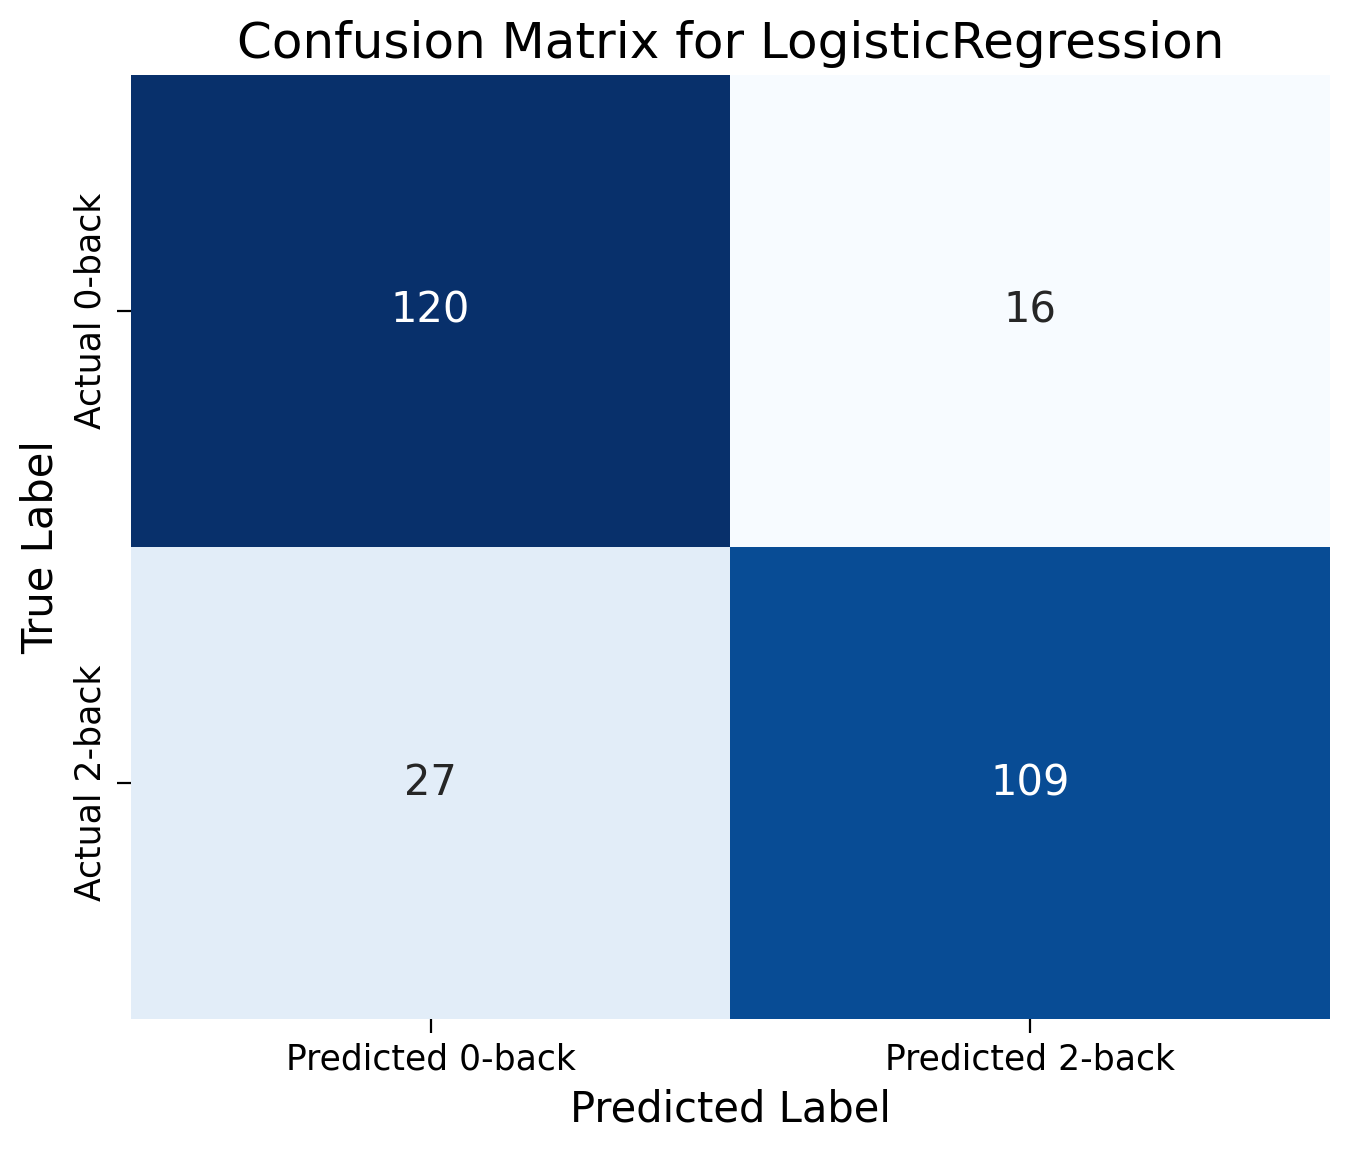




======== SVC Performance ========

--- Summary Metrics ---
Accuracy:  0.8419
Precision: 0.8442
Recall:    0.8419
F1-Score:  0.8417
ROC AUC:   0.9287

--- Classification Report ---
              precision    recall  f1-score   support

      0-back       0.82      0.88      0.85       136
      2-back       0.87      0.80      0.84       136

    accuracy                           0.84       272
   macro avg       0.84      0.84      0.84       272
weighted avg       0.84      0.84      0.84       272



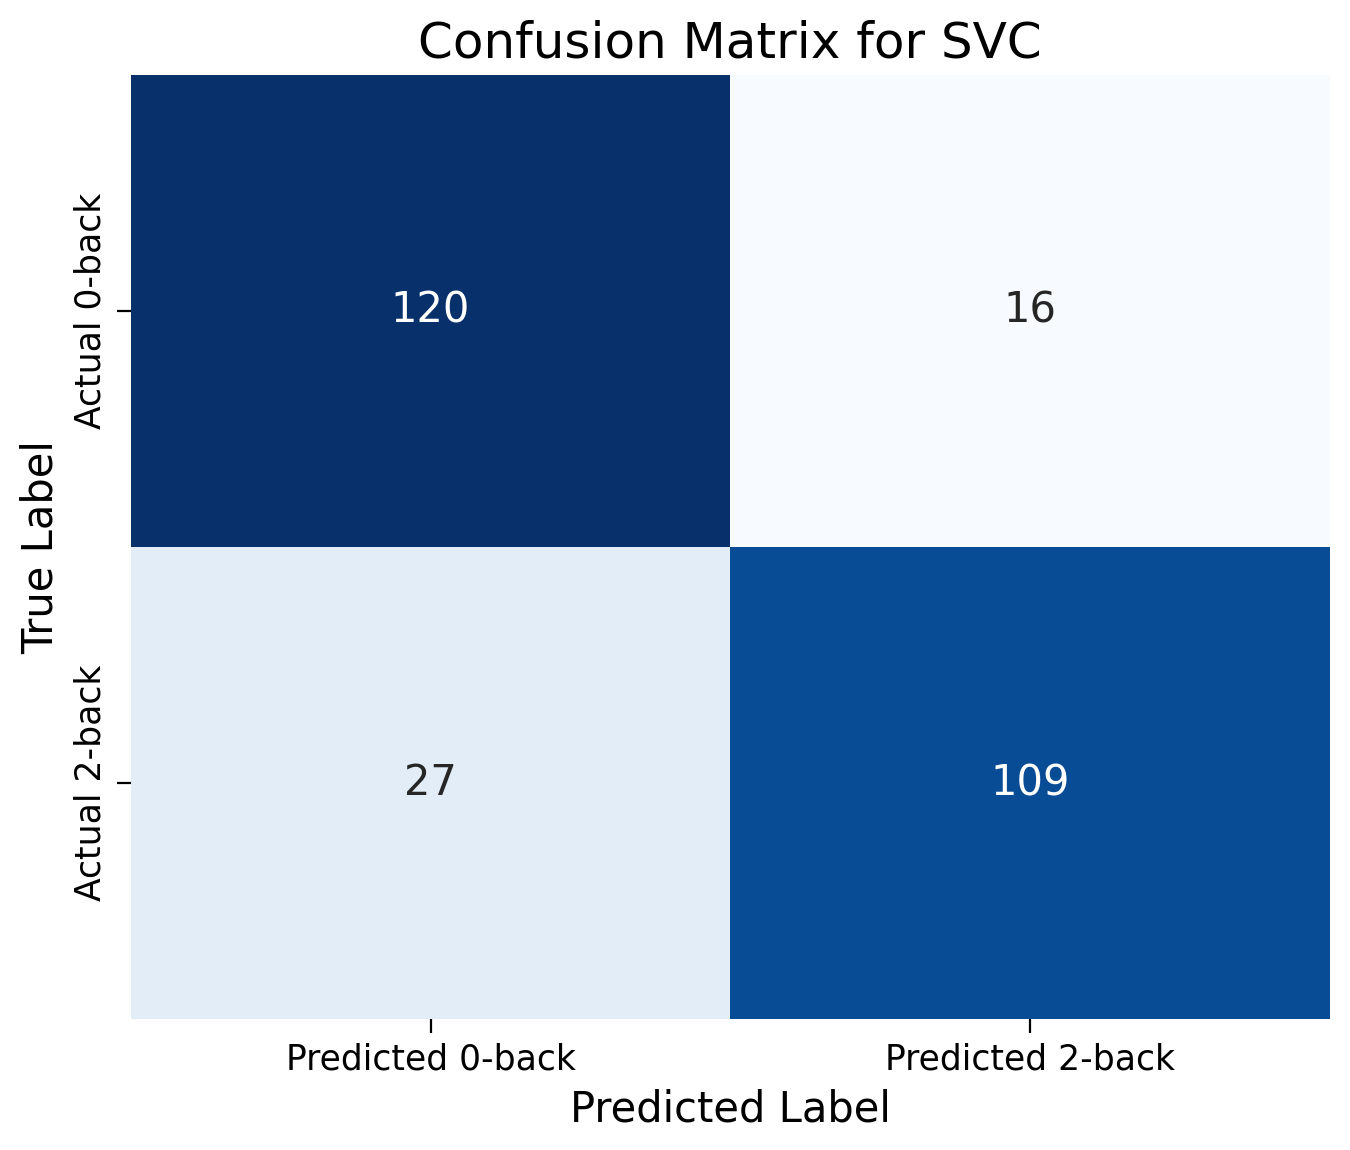




======== RandomForestClassifier Performance ========

--- Summary Metrics ---
Accuracy:  0.7978
Precision: 0.7991
Recall:    0.7978
F1-Score:  0.7976
ROC AUC:   0.8997

--- Classification Report ---
              precision    recall  f1-score   support

      0-back       0.82      0.76      0.79       136
      2-back       0.78      0.83      0.80       136

    accuracy                           0.80       272
   macro avg       0.80      0.80      0.80       272
weighted avg       0.80      0.80      0.80       272



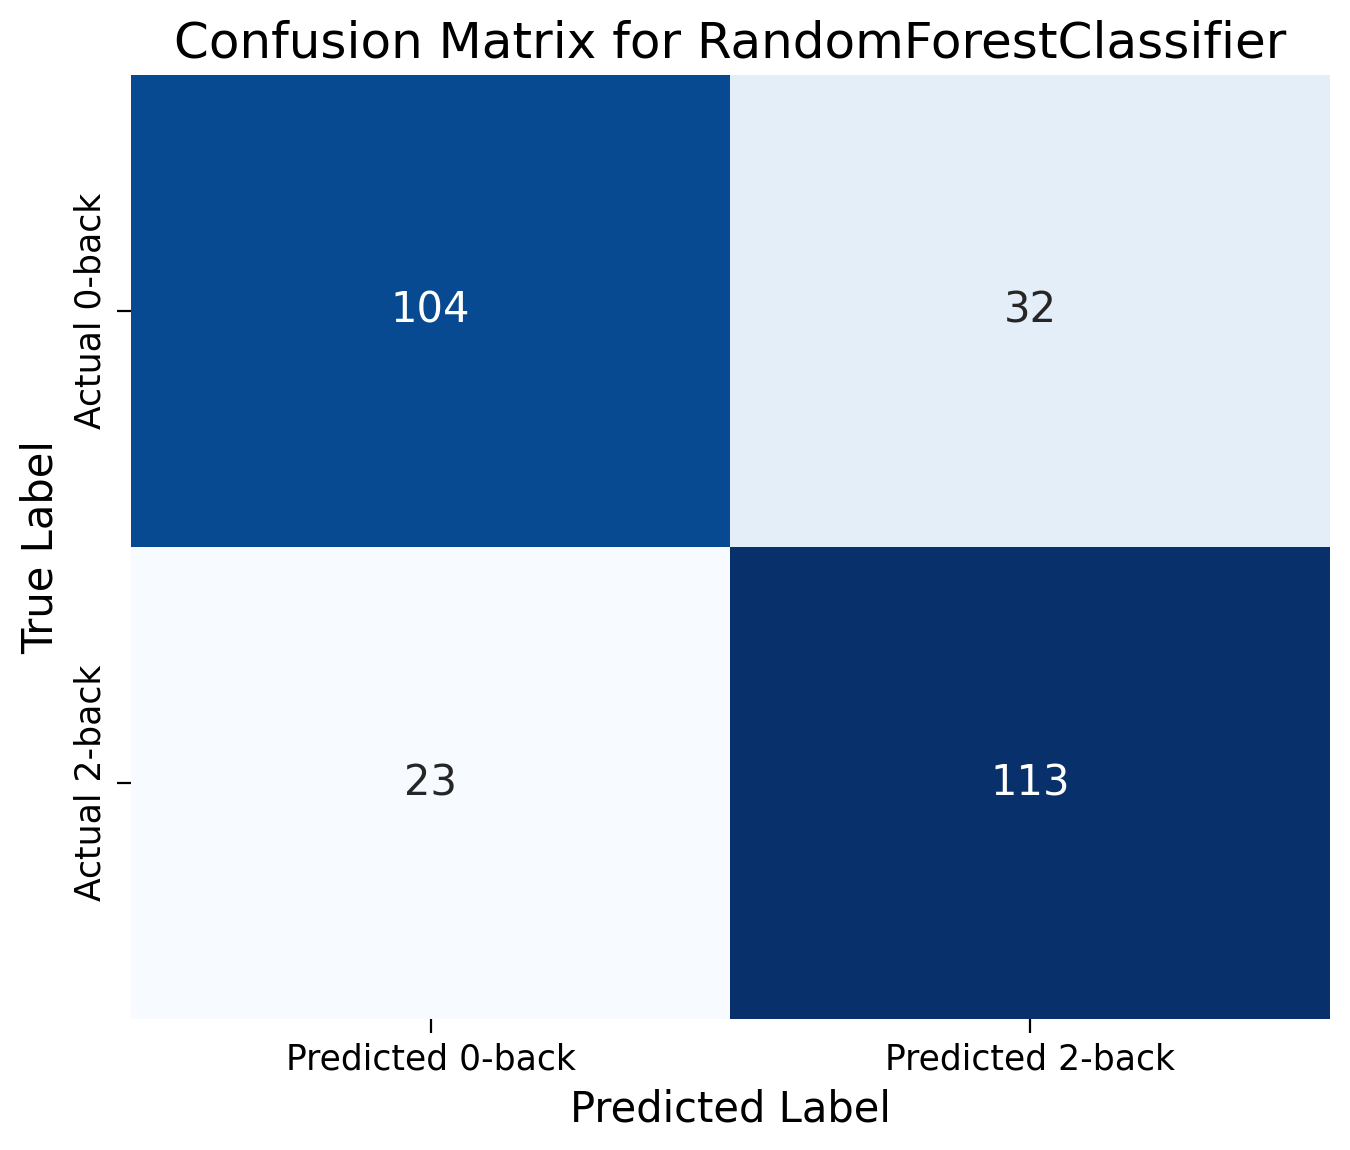




======== GradientBoostingClassifier Performance ========

--- Summary Metrics ---
Accuracy:  0.8235
Precision: 0.8235
Recall:    0.8235
F1-Score:  0.8235
ROC AUC:   0.9219

--- Classification Report ---
              precision    recall  f1-score   support

      0-back       0.82      0.82      0.82       136
      2-back       0.82      0.82      0.82       136

    accuracy                           0.82       272
   macro avg       0.82      0.82      0.82       272
weighted avg       0.82      0.82      0.82       272



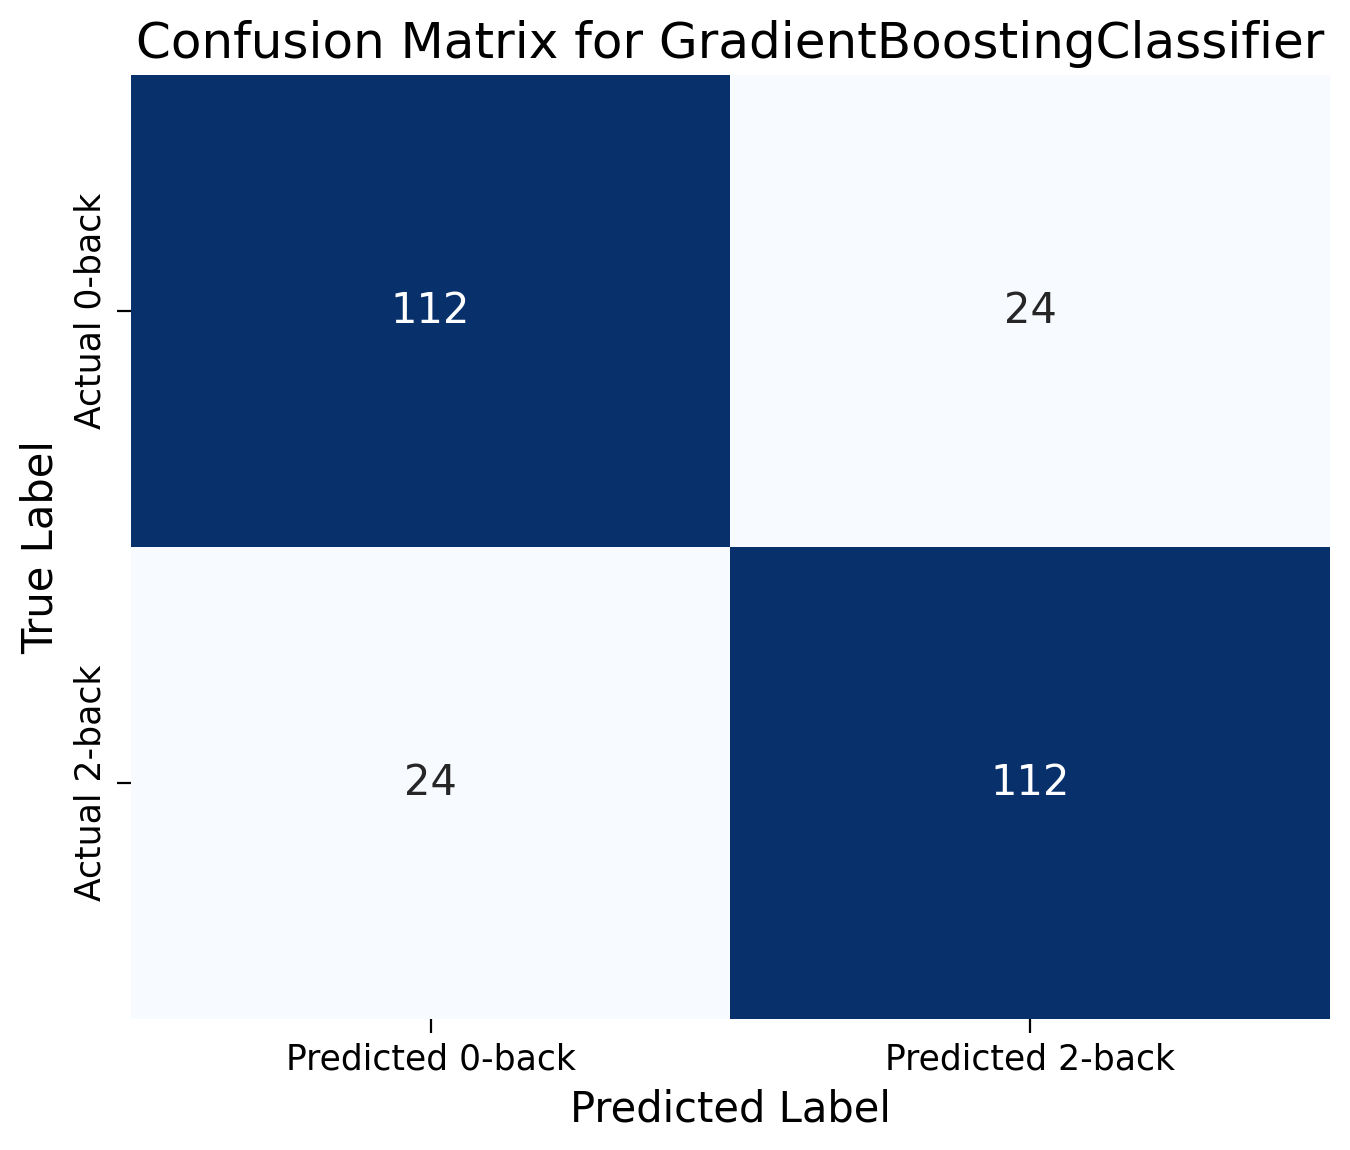




======== KNeighborsClassifier Performance ========

--- Summary Metrics ---
Accuracy:  0.7537
Precision: 0.7717
Recall:    0.7537
F1-Score:  0.7495
ROC AUC:   0.8480

--- Classification Report ---
              precision    recall  f1-score   support

      0-back       0.70      0.88      0.78       136
      2-back       0.84      0.62      0.72       136

    accuracy                           0.75       272
   macro avg       0.77      0.75      0.75       272
weighted avg       0.77      0.75      0.75       272



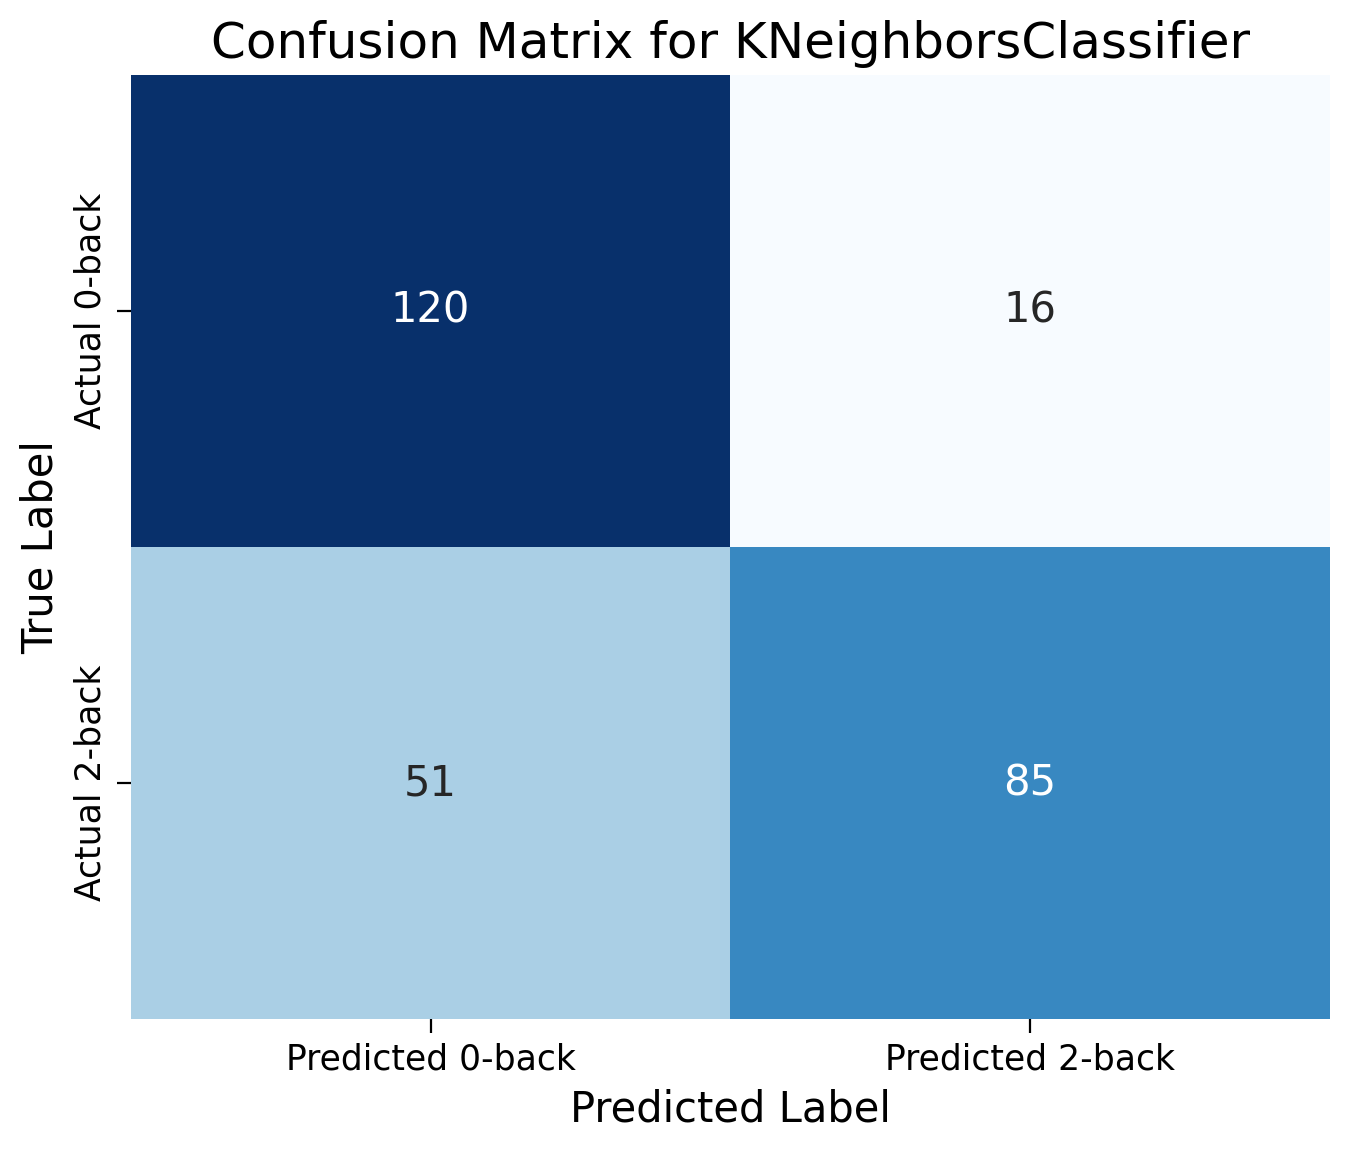




======== XGBoostClassifier Performance ========

--- Summary Metrics ---
Accuracy:  0.8162
Precision: 0.8162
Recall:    0.8162
F1-Score:  0.8162
ROC AUC:   0.9258

--- Classification Report ---
              precision    recall  f1-score   support

      0-back       0.81      0.82      0.82       136
      2-back       0.82      0.81      0.81       136

    accuracy                           0.82       272
   macro avg       0.82      0.82      0.82       272
weighted avg       0.82      0.82      0.82       272



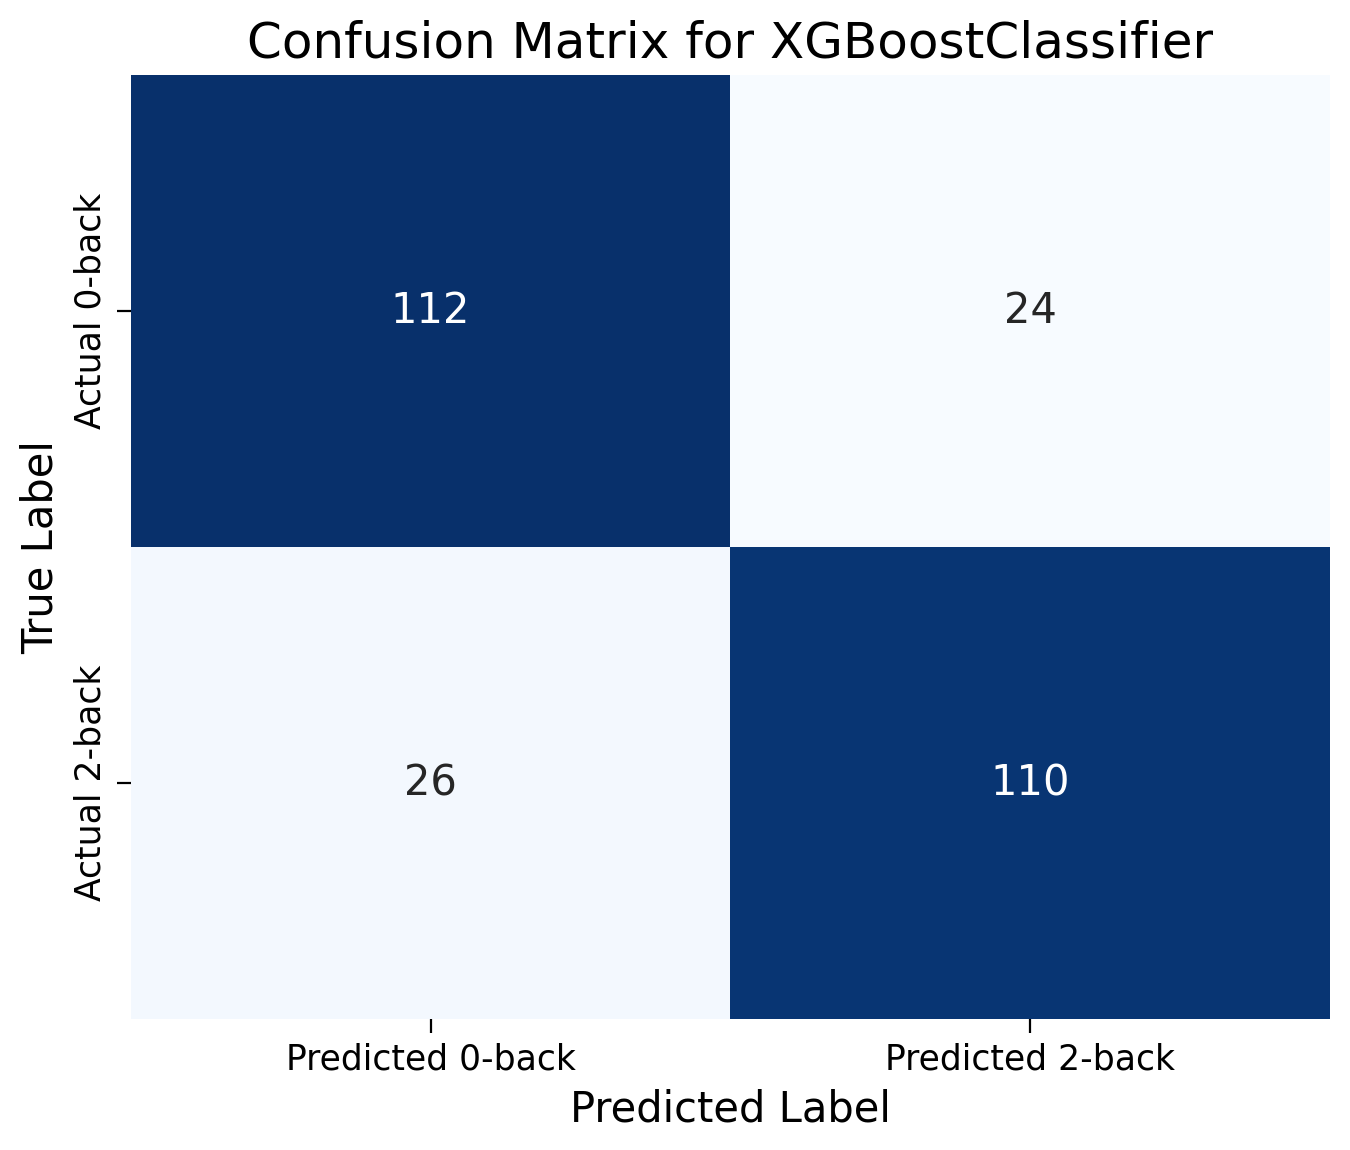



--- All Model Evaluations Complete ---


In [33]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt # Import for plotting
import seaborn as sns          # Import for plotting
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
from sklearn.pipeline import Pipeline # Ensure Pipeline is imported
from sklearn.preprocessing import StandardScaler # Ensure StandardScaler is imported

# Assume X_test and y_test are available from previous steps.
# If running this cell independently, ensure X_test and y_test are defined.
# Example dummy data if X_test/y_test are not in scope (REMOVE IN FINAL SCRIPT):
if 'X_test' not in locals() or 'y_test' not in locals():
    # Placeholder for N_FEATURES_AFTER_VECTORIZATION. Adjust based on your actual data.
    # From your previous script, if N_NETWORKS was 17, then (17 * 16) / 2 = 136 features.
    N_FEATURES_AFTER_VECTORIZATION = 136 # Or the correct number of features from your data
    num_test_samples = 300 # Example number of test samples
    X_test = np.random.rand(num_test_samples, N_FEATURES_AFTER_VECTORIZATION)
    y_test = np.random.randint(0, 2, num_test_samples)


# Directory to load models from
output_dir = "saved_models"
# List of all model filenames we expect to find
model_filenames = {
    'LogisticRegression': 'best_logistic_regression_model.joblib',
    'SVC': 'best_svc_model.joblib',
    'RandomForestClassifier': 'best_random_forest_model.joblib',
    'GradientBoostingClassifier': 'best_gradient_boosting_model.joblib',
    'KNeighborsClassifier': 'best_k_neighbors_model.joblib',
    'XGBoostClassifier': 'best_xgboost_model.joblib'
}

best_models = {}
print("Loading all saved models for evaluation...")
for name, filename in model_filenames.items():
    model_path = os.path.join(output_dir, filename)
    try:
        model = joblib.load(model_path)
        best_models[name] = model
        print(f"Loaded {name} from {model_path}")
    except FileNotFoundError:
        print(f"WARNING: Model file for {name} not found at {model_path}. Skipping evaluation for this model.")
    except Exception as e:
        print(f"ERROR: Could not load {name} from {model_path}: {e}. Skipping evaluation.")

if not best_models:
    print("No models were loaded. Exiting evaluation.")
    exit()

print("\n--- Model Evaluation Results (Printed as Tables & Displayed as Plots) ---")
print("Note: Confusion Matrix plots will open interactively. Please close each plot to continue.")

for model_name, classifier_pipeline in best_models.items():
    print(f"\n======== {model_name} Performance ========")

    try:
        # Make predictions on the unseen test data
        y_pred = classifier_pipeline.predict(X_test)

        # Get probabilities or decision function for ROC AUC
        y_proba = None
        if hasattr(classifier_pipeline, 'predict_proba'):
            try:
                y_proba = classifier_pipeline.predict_proba(X_test)[:, 1]
            except Exception as e:
                print(f"  Warning: Could not get predict_proba for {model_name} for ROC AUC: {e}")
        elif hasattr(classifier_pipeline, 'decision_function'):
            try:
                y_proba = classifier_pipeline.decision_function(X_test)
            except Exception as e:
                print(f"  Warning: Could not get decision_function for {model_name} for ROC AUC: {e}")
        
        # 1. Key Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        print("\n--- Summary Metrics ---")
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1-Score:  {f1:.4f}")

        # ROC AUC Score
        if y_proba is not None and len(np.unique(y_test)) > 1 and len(np.unique(y_proba)) > 1:
            try:
                roc_auc = roc_auc_score(y_test, y_proba)
                print(f"ROC AUC:   {roc_auc:.4f}")
            except Exception as e:
                print(f"ROC AUC:   N/A (Error calculating: {e})")
        else:
            print("ROC AUC:   N/A (Probabilities/Decision function not suitable for AUC)")

        # 2. Classification Report
        print("\n--- Classification Report ---")
        print(classification_report(y_test, y_pred, target_names=['0-back', '2-back'], zero_division=0))

        # 3. Confusion Matrix Plot (displayed interactively)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        plt.figure(figsize=(7, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Predicted 0-back', 'Predicted 2-back'],
                    yticklabels=['Actual 0-back', 'Actual 2-back'])
        plt.title(f'Confusion Matrix for {model_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show() # Display the plot and pause execution until closed

    except Exception as e:
        print(f"\n  ERROR evaluating {model_name}: {e}")
        print("  Skipping further evaluation for this model.")
    print("\n") # Add extra line for separation for next model

print("--- All Model Evaluations Complete ---")

In [37]:
import os
import numpy as np
import joblib
from sklearn.pipeline import Pipeline # Ensure Pipeline is imported
from sklearn.preprocessing import StandardScaler # Ensure StandardScaler is imported

# --- Re-define essential global variables if running this cell independently ---
# (These should already be defined if running from a continuous notebook session)
N_PARCELS = 360
HCP_DIR = r"/home/amirreza/neuromatch/hcp_task"
# ---------------------------------------------------------------------------------

print("Loading necessary data and best model...")

# Load the region information to get the parcel-to-network mapping
regions = np.load(os.path.join(HCP_DIR, "regions.npy")).T
region_info = dict(name=regions[0].tolist(),
                   network=regions[1],
                   hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2))

raw_network_names = region_info['network']
unique_network_names = np.unique(raw_network_names)
network_name_to_id = {name: i for i, name in enumerate(unique_network_names)}
parcel_to_network_mapping = np.array([network_name_to_id[name] for name in raw_network_names]).astype(int)
N_NETWORKS = len(unique_network_names)

# Load the aggregated samples and labels (assuming they are in memory or saved)
# If 'all_samples' and 'all_labels' are not in your current environment,
# you would need to re-run the "Data Aggregation" step or load them if they were saved.
# For demonstration, let's assume they are available.
if 'all_samples' not in locals() or 'all_labels' not in locals():
    print("WARNING: 'all_samples' or 'all_labels' not found. This script requires them from the initial data aggregation step.")
    print("Please ensure the data aggregation part has been run or the data has been loaded.")
    # Exit or provide a placeholder for demonstration purposes
    # For a real run, you must have your actual all_samples and all_labels
    print("Creating dummy all_samples and all_labels for demonstration. Replace with your actual data!")
    # Dummy data creation - REMOVE THIS IN YOUR FINAL SCRIPT
    all_samples = [np.random.rand(N_PARCELS, np.random.randint(30, 50)) for _ in range(1500)]
    all_labels = np.random.randint(0, 2, 1500).tolist()
    # End of dummy data creation

# --- Load the best model ---
output_dir = "saved_models"
# You can manually specify which model to load, or programmatically find the best
# Based on your previous output, SVC had the highest score.
best_model_filename = 'best_svc_model.joblib'
best_model_path = os.path.join(output_dir, best_model_filename)

try:
    loaded_model_pipeline = joblib.load(best_model_path)
    print(f"Successfully loaded model from: {best_model_path}")
except FileNotFoundError:
    print(f"ERROR: Model file not found at {best_model_path}. Please ensure it exists.")
    exit()
except Exception as e:
    print(f"ERROR: Could not load model from {best_model_path}: {e}")
    exit()

print(f"Loaded model type: {type(loaded_model_pipeline)}")
# If it's a Pipeline, it should contain the StandardScaler as the first step
if isinstance(loaded_model_pipeline, Pipeline):
    print(f"Pipeline steps: {[name for name, _ in loaded_model_pipeline.steps]}")
else:
    print("WARNING: Loaded model is not a scikit-learn Pipeline. Ensure it includes a scaler if needed.")


# --- Get 10 random indices from the original data ---
num_samples_to_predict = 5
total_samples = len(all_samples) # type: ignore
random_indices = np.random.choice(total_samples, num_samples_to_predict, replace=False)

# print(f"\nProcessing {num_samples_to_predict} random samples:")

# --- Loop through random samples, preprocess, predict, and compare ---
for i, idx in enumerate(random_indices):
    original_sample_ts = all_samples[idx] # type: ignore # Shape (N_parcels, N_timepoints)
    true_label = all_labels[idx] # type: ignore

    print(f"\n--- Sample {i+1} (Original Index: {idx}) ---")
    print(f"True Label: {true_label}")
    # print(f"Original Time Series Shape: {original_sample_ts.shape}")

    # --- Feature Extraction (Network-level FC) for this single sample ---
    # This part replicates the pre-scaling feature extraction from step 2

    # 1. Aggregate Parcel Time Series to Network Time Series
    network_time_series = np.zeros((N_NETWORKS, original_sample_ts.shape[1]))
    for network_id in range(N_NETWORKS):
        parcels_in_network = np.where(parcel_to_network_mapping == network_id)[0]
        if len(parcels_in_network) > 0:
            network_time_series[network_id, :] = np.mean(original_sample_ts[parcels_in_network, :], axis=0)

    # 2. Compute Network-level Functional Connectivity (Pearson Correlation)
    if original_sample_ts.shape[1] < 2: # Handle case with insufficient timepoints
        print("Warning: Sample has less than 2 timepoints, cannot compute valid FC. Skipping prediction for this sample.")
        predicted_label = "N/A (Insufficient Timepoints)"
        prediction_status = "Skipped"
        # Create a dummy feature vector to avoid errors if passed to pipeline, or just continue
        # For this demo, let's just skip the prediction for clarity.
        continue

    network_fc_matrix = np.corrcoef(network_time_series)
    network_fc_matrix = np.nan_to_num(network_fc_matrix, nan=0.0)

    # 3. Fisher's r-to-z Transformation
    network_fc_matrix = np.clip(network_fc_matrix, -0.9999, 0.9999)
    transformed_fc_matrix = np.arctanh(network_fc_matrix)

    # 4. Vectorize Features (Upper Triangle)
    upper_triangle_indices = np.triu_indices(N_NETWORKS, k=1)
    feature_vector_single = transformed_fc_matrix[upper_triangle_indices]

    # Reshape for prediction (predict expects 2D array: (n_samples, n_features))
    feature_vector_reshaped = feature_vector_single.reshape(1, -1)
    # print(f"Extracted Feature Vector Shape: {feature_vector_reshaped.shape}")

    # --- Predict using the loaded model ---
    predicted_label = loaded_model_pipeline.predict(feature_vector_reshaped)[0]

    # --- Compare and print results ---
    prediction_status = "CORRECT" if predicted_label == true_label else "INCORRECT"

    print(f"Predicted Label: {predicted_label}")
    print(f"Prediction Status: {prediction_status}")

print("\nRandom Sample Prediction Check Complete.")

Loading necessary data and best model...
Successfully loaded model from: saved_models/best_svc_model.joblib
Loaded model type: <class 'sklearn.pipeline.Pipeline'>
Pipeline steps: ['scaler', 'svc']

--- Sample 1 (Original Index: 319) ---
True Label: 1
Predicted Label: 1
Prediction Status: CORRECT

--- Sample 2 (Original Index: 808) ---
True Label: 0
Predicted Label: 0
Prediction Status: CORRECT

--- Sample 3 (Original Index: 739) ---
True Label: 1
Predicted Label: 1
Prediction Status: CORRECT

--- Sample 4 (Original Index: 638) ---
True Label: 0
Predicted Label: 0
Prediction Status: CORRECT

--- Sample 5 (Original Index: 1086) ---
True Label: 0
Predicted Label: 0
Prediction Status: CORRECT

Random Sample Prediction Check Complete.
